# Multiple Linear Regression - Prediciting US Life Expectancy

Given the sheer size of the features involved and for better interpretation for our final user ('Life Insurer'), it is crucial to narrow down the number of variables. There are several ways to do this but the ones we are about to list below are definitely not exhaustive. 

- Baseline Method: Using all available variables
- Naive Selection: using only top correlated features that are correlated to Life Expectancy
- Filter Method: dropping low variance features followed by removing highly correlated features
- Stepwise Selection: Adding features with p-values below certain threshold and dropping those 
- Recursive Feature Elimination: sklearn's function of greedily choosing 
- Lasso: use GridSearch to find the best penalizing parameter 'alpha' for the Lasso algo. We will then select features that have not been shrinked to 0

Once we get all the features selected by each method above, we pass those into Statsmodel's OLS function. Subsequently, we will select our most prefferred model by comparing their R2 scores, AIC (model complexity) and also consider the number of features included, which is the primary consideration here. 

Post model selection, we will then check if the chosen model satisfies the assumptions of a regression; no multicollinearity between selected features, homosceasticity and normality of errors. In the end, we shall evaluate the model if it fits the purpose for our final user.

First let's import all the required libraries.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import pylab
import warnings

from functions import *

from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, KFold, GridSearchCV
from sklearn.metrics import r2_score
from sklearn.feature_selection import VarianceThreshold, RFECV, RFE
from sklearn.preprocessing import StandardScaler

from statsmodels.regression.linear_model import OLS
from statsmodels.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor

from scipy import stats

sns.set_style('darkgrid')
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

%load_ext autoreload
%autoreload 2

Import the data which was previously cleaned in a seperate notebook.

In [2]:
df_clean = pd.read_csv('clean_data.csv', index_col = [0])
print ('Number of rows:', df_clean.shape[0])
print ('Number of columns:', df_clean.shape[1])

Number of rows: 3142
Number of columns: 66


Now, let's drop both of the string columns 'State Abbreviation' and 'Name'. We then split the data into X feature and y target as the 'Life_expectancy'.

In [3]:
to_drop = ['State_Abbreviation', 'Name', 'Life_expectancy', 'Premature_age-adjusted_mortality', 'Premature_death', 'Injury_deaths', 'Teen_births']

X = df_clean.drop(to_drop, axis = 1)
y = df_clean['Life_expectancy']

Split into training and testing dataset, setting the test size to 25% and a random state of 1 to ensure reproducibility of data.

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 1)

Given one our end goal is to rank features, this is not possible as the features are on different unit scales. To enable comparison, let's standardized our dataset using Sklearn's Standard Scaler which transforms the data into its relevant Z-scores (ie. number of standard deviation away from the mean).

In [5]:
scx = StandardScaler()
scy = StandardScaler()

X_train_scaled = pd.DataFrame(scx.fit_transform(X_train), columns = X_train.columns)
X_test_scaled = pd.DataFrame(scx.transform(X_test), columns = X_test.columns)

y_train_scaled = np.concatenate(scy.fit_transform(np.array(y_train).reshape(-1,1)))
y_test_scaled = np.concatenate(scy.transform(np.array(y_test).reshape(-1,1)))

Finally ahead of running all the different methods, let's create a dataframe to store all method outcomes for better readability and comparison.

In [6]:
all_model_summary_df = pd.DataFrame([], 
                                    columns = ['model', 
                                               'R2_train', 'CV_R2_train', 
                                               'AIC', 'n_features', '>0.05_pvalues'])


all_model_summary_df['model'] = ['Baseline', 'Naive - Top Correlation',
                                 'Filter', 
                                 'RFE', 'Stepwise',
                                 'Lasso']

all_model_summary_df

,model,R2_train,CV_R2_train,AIC,n_features,>0.05_pvalues
0,Baseline,NaN,NaN,NaN,NaN,NaN
1,Naive - Top Correlation,NaN,NaN,NaN,NaN,NaN
2,Filter,NaN,NaN,NaN,NaN,NaN
3,RFE,NaN,NaN,NaN,NaN,NaN
4,Stepwise,NaN,NaN,NaN,NaN,NaN
5,Lasso,NaN,NaN,NaN,NaN,NaN


## 1. Baseline - All available features

Cool, we now start off by using all 63 z-scaled features to run the OLS model, followed by calculating all of the R2 scores, the AIC, number of features and number of features with p-values of more than 0.05.

In [7]:
linreg_baseline = LinearRegression()
linreg_baseline_mean_score = round(np.mean(cross_val_score(linreg_baseline, X_train_scaled, y_train_scaled, cv = 5)), 3)

In [8]:
baseline_OLS = OLS(y_train_scaled, add_constant(X_train_scaled)).fit()

baseline_predictions = baseline_OLS.predict(add_constant(X_test_scaled))
baseline_train_r2 = round(baseline_OLS.rsquared, 3)

baseline_errors = y_test_scaled - baseline_predictions
baseline_test_r2 = round(r2_score(y_test_scaled, baseline_predictions), 3)

print ('Baseline Train R-Squared:', baseline_train_r2)
print ('Baseline CV Score R-Squared:', linreg_baseline_mean_score)

Baseline Train R-Squared: 0.755
Baseline CV Score R-Squared: 0.724


Without taking any further assumptions on this method, let's update our initial table.

In [9]:
update_model(all_model_summary_df, 'Baseline', baseline_OLS, [baseline_train_r2, linreg_baseline_mean_score])

In [10]:
all_model_summary_df

,model,R2_train,CV_R2_train,AIC,n_features,>0.05_pvalues
0,Baseline,0.755,0.724,3493,60,27
1,Naive - Top Correlation,NaN,NaN,NaN,NaN,NaN
2,Filter,NaN,NaN,NaN,NaN,NaN
3,RFE,NaN,NaN,NaN,NaN,NaN
4,Stepwise,NaN,NaN,NaN,NaN,NaN
5,Lasso,NaN,NaN,NaN,NaN,NaN


## 2. Naive Selection - Subset of features with highest correlation to Life Expectancy

Given we've 'blindly' included all features in the baseline model, let's try and narrow these down to only include features which are highly correlated with our target variabe, 'Life Expectancy'. First, we initiated a correlation matrix and set our target correlation threshold to 0.65.

In [11]:
target_correlation_threshold = 0.65

absolute_correlation = abs(X_train.corrwith(y_train))
final = absolute_correlation[absolute_correlation > 0.65]
final

Poor_physical_health_days     0.670166
Adult_smoking                 0.701254
Children_in_poverty           0.656341
Frequent_physical_distress    0.675509
Frequent_mental_distress      0.695187
dtype: float64

Using a 0.65 threshold, we've narrowed down from 64 to 8 features. Using these 8 features, let's create another OLS model and evaluate its performance.

In [12]:
linreg_naive = LinearRegression()
linreg_naive_mean_score = round(np.mean(cross_val_score(linreg_naive, 
                                                        X_train_scaled[final.index], 
                                                        y_train_scaled, cv = 5)), 3)

In [13]:
naive_OLS = OLS(y_train_scaled, add_constant(X_train_scaled[final.index])).fit()

naive_predictions = naive_OLS.predict(add_constant(X_test_scaled[final.index]))
naive_train_r2 = round(naive_OLS.rsquared, 3)

naive_errors = y_test_scaled - naive_predictions
naive_test_r2 = round(r2_score(y_test_scaled, naive_predictions), 3)

print ('Naive Train R-Squared:', naive_train_r2)
print ('Naive CV Score R-Squared:', linreg_naive_mean_score)

Naive Train R-Squared: 0.577
Naive CV Score R-Squared: 0.571


In [14]:
update_model(all_model_summary_df, 'Naive - Top Correlation', naive_OLS, [naive_train_r2, linreg_naive_mean_score])

In [15]:
all_model_summary_df

,model,R2_train,CV_R2_train,AIC,n_features,>0.05_pvalues
0,Baseline,0.755,0.724,3493,60,27
1,Naive - Top Correlation,0.577,0.571,4670,6,1
2,Filter,NaN,NaN,NaN,NaN,NaN
3,RFE,NaN,NaN,NaN,NaN,NaN
4,Stepwise,NaN,NaN,NaN,NaN,NaN
5,Lasso,NaN,NaN,NaN,NaN,NaN


Just by using the 8 (9 with constant) top correlated features, we get almost similar results to our Baseline model!

## 3. Filter - drop features with no / low variance & high correlation with other features

One of the pitfalls of the above methods is that we might have potentially ignored other useful features that might be of use to our final user. 

Coupled with the above, the previously contemplated model might include various highly correlated features, violating the assumptions of a regression model. As such, let's try out best to find a middle ground by using by:

- dropping features with no or low variance. These features typically do not add much predictive value in a model
- dropping features which are highly correlated

Let's start of by dropping features with no or low variance. We can utilize Sklearn's 'variance_threshold' tool to solve this.

In [16]:
variance_threshold = 0.00

low_var_filter = VarianceThreshold(threshold = variance_threshold).fit(X_train_scaled)

dropped_cols = X_train_scaled.columns[low_var_filter.get_support() == False]
print ('Number of low variance features:', len(dropped_cols))
print ('Low variance features:', list(dropped_cols))

Number of low variance features: 1
Low variance features: ['Release_Year']


In [17]:
High_Var_Features = X_train_scaled.drop(dropped_cols, axis = 1)

Next, let's further narrow down features by excluding highly correlated features. We have defined this as those with pearson's r of > 0.6.

In [18]:
corr_matrix = High_Var_Features.corr()
correlated_features = set()

corr_threshold = 0.6

for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > corr_threshold:
            colname = corr_matrix.columns[i]
            correlated_features.add(colname)

correlated_features
print ('Number of features to drop:', len(correlated_features))
print ('Features to drop: \n', list(correlated_features))

Number of features to drop: 21
Features to drop: 
 ['Median_household_income', 'Insufficient_sleep', 'Uninsured_adults', 'Physical_inactivity', 'Children_in_single-parent_households', 'Poor_mental_health_days', 'Limited_access_to_healthy_foods', 'Diabetes_prevalence', 'Adult_smoking', 'Children_eligible_for_free_or_reduced_price_lunch', 'Poor_physical_health_days', 'Food_insecurity', 'Excessive_drinking', 'Severe_housing_cost_burden', 'Percentage_of_households_with_high_housing_costs', 'Uninsured_children', 'Frequent_physical_distress', 'Frequent_mental_distress', 'Some_college', 'Percentage_of_households_with_overcrowding', 'Children_in_poverty']


In [19]:
High_Var_Features_Low_Corr = High_Var_Features.drop(list(correlated_features), axis = 1)

In [20]:
linreg_filter = LinearRegression()
linreg_filter_mean_score = round(np.mean(cross_val_score(linreg_filter, 
                                                        X_train_scaled[High_Var_Features_Low_Corr.columns], 
                                                        y_train_scaled, cv = 5)), 3)

In [21]:
filter_OLS = OLS(y_train_scaled, add_constant(X_train_scaled[High_Var_Features_Low_Corr.columns])).fit()

filter_predictions = filter_OLS.predict(add_constant(X_test_scaled[High_Var_Features_Low_Corr.columns]))
filter_train_r2 = round(filter_OLS.rsquared, 3)

filter_errors = y_test_scaled - filter_predictions
filter_test_r2 = round(r2_score(y_test_scaled, filter_predictions), 3)

In [22]:
print ('Filter Train R-Squared:', filter_train_r2)
print ('Filter CV Score R-Squared:', linreg_filter_mean_score)

Filter Train R-Squared: 0.702
Filter CV Score R-Squared: 0.679


In [23]:
update_model(all_model_summary_df, 'Filter', filter_OLS, [filter_train_r2, linreg_filter_mean_score])

In [24]:
all_model_summary_df

,model,R2_train,CV_R2_train,AIC,n_features,>0.05_pvalues
0,Baseline,0.755,0.724,3493,60,27
1,Naive - Top Correlation,0.577,0.571,4670,6,1
2,Filter,0.702,0.679,3909,38,15
3,RFE,NaN,NaN,NaN,NaN,NaN
4,Stepwise,NaN,NaN,NaN,NaN,NaN
5,Lasso,NaN,NaN,NaN,NaN,NaN


Looks like the filter method performs on a less satisfactory basis across test accuracy, model complexity and the higher number of features (which still might be overwhelming for our end user!)

## 4. Wrapper - Recursive Feature Elimination

In [25]:
linreg = LinearRegression()
rfecv = RFECV(linreg, step = 1, scoring='r2', cv=10)
rfecv.fit(X_train_scaled, y_train_scaled)

RFECV(cv=10,
      estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                 normalize=False),
      min_features_to_select=1, n_jobs=None, scoring='r2', step=1, verbose=0)

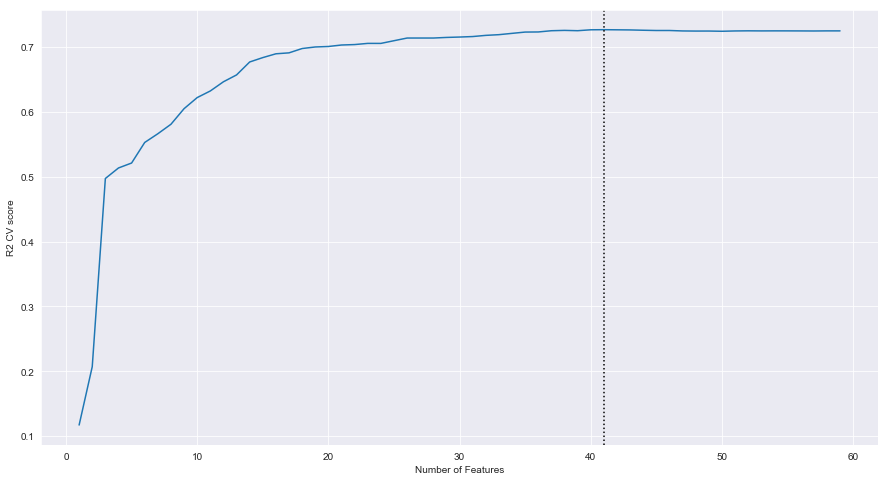

<Figure size 432x288 with 0 Axes>

In [56]:
plt.figure(figsize=(15, 8))
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.axvline(rfecv.n_features_, linestyle = ':', color = 'black')
plt.xlabel('Number of Features')
plt.ylabel('R2 CV score')
plt.show()
plt.savefig('RFECV.png')

In [27]:
RFE_columns = X_train_scaled.columns[rfecv.get_support()]

In [28]:
linreg_RFE = LinearRegression()
linreg_RFE_mean_score = round(np.mean(cross_val_score(linreg_RFE, 
                                                        X_train_scaled[RFE_columns], 
                                                        y_train_scaled, cv = 5)), 3)

In [29]:
RFE_OLS = OLS(y_train_scaled, add_constant(X_train_scaled[RFE_columns])).fit()

RFE_predictions = RFE_OLS.predict(add_constant(X_test_scaled[RFE_columns]))
RFE_train_r2 = round(RFE_OLS.rsquared, 3)

RFE_errors = y_test_scaled - RFE_predictions
RFE_test_r2 = round(r2_score(y_test_scaled, RFE_predictions), 3)

In [30]:
print ('RFE Train R-Squared:', round(RFE_train_r2, 2))
print ('RFE CV Score R-Squared:', linreg_RFE_mean_score)

RFE Train R-Squared: 0.75
RFE CV Score R-Squared: 0.73


In [31]:
update_model(all_model_summary_df, 'RFE', RFE_OLS, [RFE_train_r2, linreg_RFE_mean_score])

In [32]:
all_model_summary_df

,model,R2_train,CV_R2_train,AIC,n_features,>0.05_pvalues
0,Baseline,0.755,0.724,3493,60,27
1,Naive - Top Correlation,0.577,0.571,4670,6,1
2,Filter,0.702,0.679,3909,38,15
3,RFE,0.752,0.73,3482,42,10
4,Stepwise,NaN,NaN,NaN,NaN,NaN
5,Lasso,NaN,NaN,NaN,NaN,NaN


This looks slightly better than the filter method however the number of features still remains an issue here.

## 5. Stepwise Selection - Combination of Forward and Backward feature selection

In [33]:
stepwise_columns = stepwise_selection(X_train_scaled, y_train_scaled, threshold_in = 0.01, verbose=True)

Add  Adult_smoking                  with p-value 0.0
Add  Motor_vehicle_crash_deaths     with p-value 8.13982e-86
Add  Diabetes_prevalence            with p-value 2.34273e-51
Add  Food_insecurity                with p-value 2.48287e-27
Add  Drug_overdose_deaths           with p-value 9.27658e-30
Add  Driving_alone_to_work          with p-value 2.76458e-23
Add  Sexually_transmitted_infections with p-value 1.64372e-21
Add  Median_household_income        with p-value 1.81715e-19
Add  Child_mortality                with p-value 4.36577e-13
Add  Firearm_fatalities             with p-value 5.21154e-09
Add  Air_pollution_-_particulate_matter with p-value 1.35673e-08
Add  %_not_proficient_in_English    with p-value 2.91693e-07
Add  Percentage_of_households_with_overcrowding with p-value 3.9601e-14
Add  Mammography_screening          with p-value 1.77806e-09
Drop Food_insecurity                with p-value 0.14547
Add  %_Rural                        with p-value 3.59683e-11
Add  Preventable_hos

In [34]:
print ('Number of stepwise columns:', len(stepwise_columns))

Number of stepwise columns: 21


In [35]:
linreg_stepwise = LinearRegression()
linreg_stepwise_mean_score = round(np.mean(cross_val_score(linreg_stepwise, 
                                                        X_train_scaled[stepwise_columns], 
                                                        y_train_scaled, cv = 5)), 3)

In [36]:
stepwise_OLS = OLS(y_train_scaled, add_constant(X_train_scaled[stepwise_columns])).fit()

stepwise_predictions = stepwise_OLS.predict(add_constant(X_test_scaled[stepwise_columns]))
stepwise_train_r2 = round(stepwise_OLS.rsquared, 3)

stepwise_errors = y_test_scaled - stepwise_predictions
stepwise_test_r2 = round(r2_score(y_test_scaled, stepwise_predictions), 3)

In [37]:
print ('Stepwise Train R-Squared:', round(stepwise_train_r2, 2))
print ('Stepwise CV Score R-Squared:', linreg_RFE_mean_score)

Stepwise Train R-Squared: 0.74
Stepwise CV Score R-Squared: 0.73


In [38]:
update_model(all_model_summary_df, 'Stepwise', stepwise_OLS, [stepwise_train_r2, linreg_stepwise_mean_score])

In [39]:
all_model_summary_df

,model,R2_train,CV_R2_train,AIC,n_features,>0.05_pvalues
0,Baseline,0.755,0.724,3493,60,27
1,Naive - Top Correlation,0.577,0.571,4670,6,1
2,Filter,0.702,0.679,3909,38,15
3,RFE,0.752,0.73,3482,42,10
4,Stepwise,0.736,0.722,3596,22,1
5,Lasso,NaN,NaN,NaN,NaN,NaN


Now, this looks better than before with a less complex model, fairly reasonable test R2 and a manageable amount of features.

## 6. Lasso

First we set the all the hyperparameters we are interested in tuning, primarily the 'penalizing' parameters (alpha). The GridSearch function will be able to obtain the best parameters for us by evaluating them using R2 score.

In [40]:
model = Lasso()
lasso_params = {'alpha' : [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]}

grid_obj = GridSearchCV(estimator = model, 
                        param_grid = lasso_params, 
                        scoring = 'r2',
                        cv = 5,
                        n_jobs = -1)

grid_obj = grid_obj.fit(X_train_scaled, y_train_scaled)
grid_obj.best_params_

{'alpha': 0.05}

Looks like the best alpha level is 0.05.

In [41]:
final_lasso = grid_obj.best_estimator_.fit(X_train_scaled, y_train_scaled)
lasso_coef = pd.Series(final_lasso.coef_, index = X_train_scaled.columns)
lasso_coef = lasso_coef[lasso_coef != 0]

print ('Number of non-0 coef:', len(lasso_coef))
print ('Selected lasso coef:\n', lasso_coef)

Number of non-0 coef: 24
Selected lasso coef:
 Poor_mental_health_days                             -0.006075
Adult_smoking                                       -0.186576
Adult_obesity                                       -0.014473
Physical_inactivity                                 -0.084175
Excessive_drinking                                   0.007923
Sexually_transmitted_infections                     -0.079343
Preventable_hospital_stays                          -0.029920
Mammography_screening                                0.013501
Children_in_poverty                                 -0.062329
Children_in_single-parent_households                -0.003642
Violent_crime                                       -0.003283
Air_pollution_-_particulate_matter                  -0.027500
Driving_alone_to_work                               -0.092817
Child_mortality                                     -0.071881
Frequent_mental_distress                            -0.079920
Diabetes_prevalence    

In [42]:
linreg_lasso = LinearRegression()
linreg_lasso_mean_score = round(np.mean(cross_val_score(linreg_lasso, 
                                                        X_train_scaled[lasso_coef.index], 
                                                        y_train_scaled, cv = 5)), 3)

In [43]:
Lasso_OLS = OLS(y_train_scaled, add_constant(X_train_scaled[lasso_coef.index])).fit()

Lasso_predictions = Lasso_OLS.predict(add_constant(X_test_scaled[lasso_coef.index]))
Lasso_train_r2 = round(Lasso_OLS.rsquared, 3)

Lasso_errors = y_test_scaled - Lasso_predictions
Lasso_test_r2 = round(r2_score(y_test_scaled, Lasso_predictions), 3)

In [44]:
print ('Lasso Train R-Squared:', round(Lasso_train_r2, 2))
print ('Lasso CV Score R-Squared:', linreg_lasso_mean_score)

Lasso Train R-Squared: 0.72
Lasso CV Score R-Squared: 0.709


In [45]:
update_model(all_model_summary_df, 'Lasso', Lasso_OLS, [Lasso_train_r2, linreg_lasso_mean_score])

In [46]:
all_model_summary_df

,model,R2_train,CV_R2_train,AIC,n_features,>0.05_pvalues
0,Baseline,0.755,0.724,3493,60,27
1,Naive - Top Correlation,0.577,0.571,4670,6,1
2,Filter,0.702,0.679,3909,38,15
3,RFE,0.752,0.73,3482,42,10
4,Stepwise,0.736,0.722,3596,22,1
5,Lasso,0.723,0.709,3713,25,8


# Final Model Selection - Stepwise Selection

Okay, looking purely by R2 scores, model complexity and optimum number of features, we have decided to go for the Stepwise model. However we will still need to check if the model fits the regression assumptions. First let check for multicollinearity using the VIF metric. 

In [47]:
stepwise_baseline = X_train_scaled[stepwise_columns]
stepwise_baseline['Intercept'] = 1

stepwise_VIF = pd.DataFrame()
stepwise_VIF["variables"] = stepwise_baseline.columns
stepwise_VIF["VIF"] = [variance_inflation_factor(stepwise_baseline.values, i) for i in range(stepwise_baseline.shape[1])]

stepwise_VIF

,variables,VIF
0,Adult_smoking,3.030270
1,Motor_vehicle_crash_deaths,1.959786
2,Diabetes_prevalence,3.621573
3,Drug_overdose_deaths,1.157858
4,Driving_alone_to_work,1.843965
5,Sexually_transmitted_infections,1.797629
6,Median_household_income,2.899842
7,Child_mortality,1.565470
8,Firearm_fatalities,1.454857
9,Air_pollution_-_particulate_matter,1.756740


Cool, since no features are more than 10, multicollinearity is not a big concern here. Next we check for homoscedasticity by plotting the residuals.

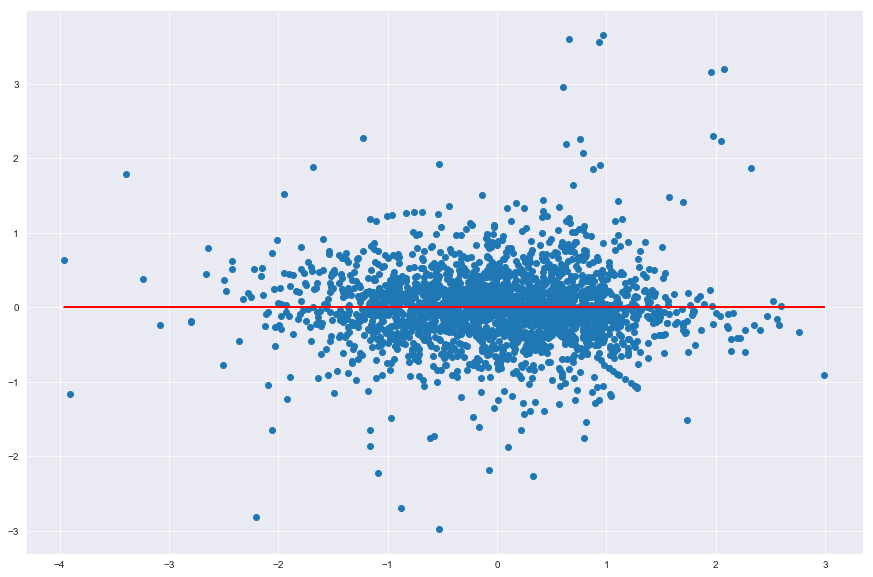

In [48]:
stepwise_updated = X_train_scaled[stepwise_columns]
stepwise_updated.insert(0, 'const', 1)

stepwise_OLS.predict(stepwise_updated)
len(stepwise_OLS.resid)

plt.figure(figsize = (15,10))
plt.scatter(stepwise_OLS.predict(stepwise_updated), stepwise_OLS.resid)
plt.plot(stepwise_OLS.predict(stepwise_updated), [0 for i in range(len(X_train_scaled))], color = 'r')
plt.show()

This looks fine with no concerning trends. No we look at the normality of the errors using the QQ plot and distribution of errors

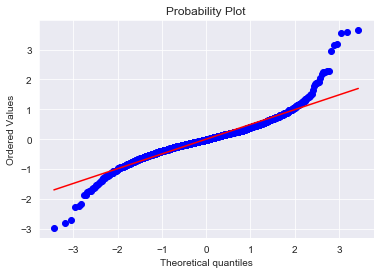

In [49]:
residuals = stepwise_OLS.resid
fig = stats.probplot(residuals, dist="norm", plot=pylab)

Not perfect. This is likely caused by outliers. Let's investigate the outliers for the target and see if there are any significant changes between quantiles/

In [50]:
updated_scaled = X_train_scaled
updated_scaled['Life_expectancy'] = y_train_scaled

list_range = np.linspace(0, 0.1, 11)
for i in list_range:
    print (round(i, 5), round(updated_scaled.Life_expectancy.quantile(i),2))

0.0 -5.08
0.01 -2.36
0.02 -2.07
0.03 -1.86
0.04 -1.72
0.05 -1.6
0.06 -1.5
0.07 -1.43
0.08 -1.36
0.09 -1.31
0.1 -1.23


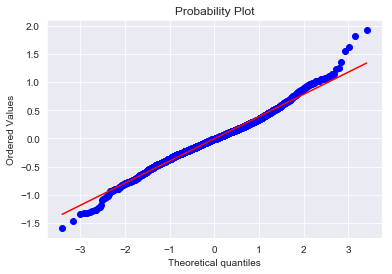

In [51]:
to_use_scaled = updated_scaled[(updated_scaled.Life_expectancy < 1.5) & (updated_scaled.Life_expectancy > -1.5)]
to_use_x_train_scaled = to_use_scaled.drop(['Life_expectancy'], axis = 1)
to_use_y_train_scaled = to_use_scaled.Life_expectancy

stepwise_OLS_scaled_outliers = OLS(to_use_y_train_scaled, to_use_x_train_scaled[stepwise_columns]).fit()
residuals_outlier = stepwise_OLS_scaled_outliers.resid
stats.probplot(residuals_outlier, dist="norm", plot=pylab)
pylab.show()

Now, let's check if our model performance has deteriorated post dropping outliers.

In [52]:
updated_predictions = stepwise_OLS_scaled_outliers.predict(X_test_scaled[stepwise_columns])
updated_test_r2 = round(r2_score(y_test_scaled, updated_predictions), 3)
print ('Test R-Squared:', updated_test_r2)

Test R-Squared: 0.671


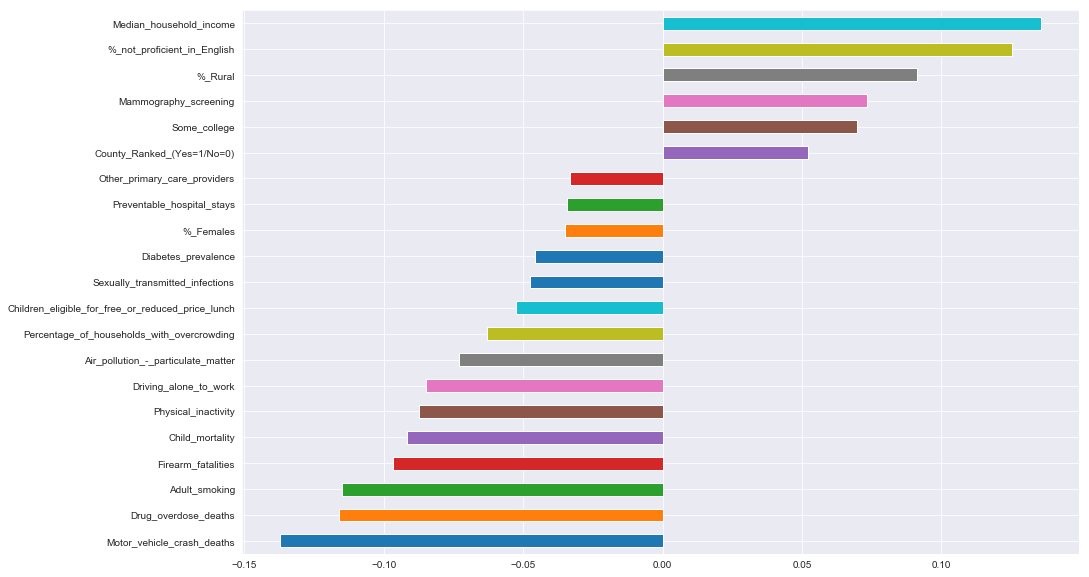

In [53]:
stepwise_OLS_scaled_outliers.params.sort_values().plot(kind = 'barh', figsize = (15,10))
plt.show()

# Conclusion and future work

To conclude, it is important to emphasize that whilst we have chosen the model above, there are many other methods out there which may result in a better model. That said, the above model should at least provide our end user with the crucial indicators for estimating life expectancy.

For future work, we will look to explore:
- investigate performance of forward / backward selection, Ridge regression, interactions and polynomials
- user other models apart from OLS, ie RF, CART, etc
- investigate indirect correlations between features